# Анализ поведения пользователей мобильного приложения

## Введение

### Цель и задачи проекта

**Цель работы** - разобраться в поведении пользователей мобильного приложения. Заказчик - стартап, который продаёт продукты питания.

**Задачи**:
* Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
* Исследовать результаты A/A/B-эксперимента по замене шрифта в приложении. Выяснить, какой шрифт лучше? 

**Ход работы**:
* *Загрузка и предобработка данных*.
---
* *Изучение и проверка данных*:
    1. сколько всего событий в логе?
    2. сколько всего пользователей в логе?
    3. сколько в среднем событий приходится на пользователя?
    4. данными за какой период я располагаю?:
        * найти максимальную и минимальную дату; 
        * построить гистограмму по дате и времени. Проверить полноту данных; 
    5. много ли событий и пользователей потеряется, если отбросить старые данные?;
    6. проверить, что есть пользователи из всех трёх экспериментальных групп.
---    
* *Изучить воронку событий*:
    1. посмотреть, какие события есть в логах, как часто они встречаются;
    2. посчитать, сколько пользователей совершали каждое из этих событий;
    3. предположить, в каком порядке происходят события;
    4. по воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки;
    5. на каком шаге теряется больше всего пользователей?;
    6. какая доля пользователей доходит от первого события до оплаты?
---
* *Изучение результатов эксперимента*:
    1. сколько пользователей в каждой экспериментальной группе?
    2. проверить, находят ли статистические критерии разницу между выборками из контрольных групп 246 и 247;
    3. выбрать самое популярное событие: 
        * посчитать число пользователей, совершивших это событие в каждой из контрольных групп, 
        * посчитать долю пользователей, совершивших это событие,
        * проверить, будет ли отличие между группами статистически достоверным, 
        * проделать то же самое для всех других событий,
    4. аналогично исследовать группу с изменённым шрифтом: 
        * сравнить результаты с каждой из контрольных групп в отдельности по каждому событию,
        * сравнить результаты с объединённой контрольной группой

*Описание данных*:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: `246` и `247` — контрольные группы, а `248` — экспериментальная.

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import plotly.io as pio

import warnings

In [2]:
pio.renderers.default = "png"
warnings.filterwarnings(action='ignore')

In [3]:
try:
    logs = pd.read_csv('logs_exp.csv', sep = '\t')
except:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

Данные загружены, приступим к предобработке.

## Подготовка данных

In [4]:
logs.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [5]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Для начала переименуем столбцы

In [6]:
logs.rename(
    columns={
        "EventName": "event",
        "DeviceIDHash": "user_id",
        "EventTimestamp": "date",
        "ExpId": "group",
    },
    inplace=True,
)

In [7]:
logs.head(1)

,event,user_id,date,group
0,MainScreenAppear,4575588528974610257,1564029816,246


Сменим формат даты в столбце `date`.

In [8]:
logs["date_and_time"] = pd.to_datetime(logs["date"], unit='s')
logs["date"] = pd.to_datetime(
     logs["date"].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
)
logs.head(1)

,event,user_id,date,group,date_and_time
0,MainScreenAppear,4575588528974610257,2019-07-25,246,2019-07-25 04:43:36


In [9]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event          244126 non-null  object        
 1   user_id        244126 non-null  int64         
 2   date           244126 non-null  datetime64[ns]
 3   group          244126 non-null  int64         
 4   date_and_time  244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Формат даты изменили, пропусков нет.

Для удобства изменим названия групп в столбце `group`

In [10]:
logs['group'].value_counts()

248    85747
246    80304
247    78075
Name: group, dtype: int64

In [11]:
logs['group'] = logs['group'].astype(str).replace({'246': 'A1', '247' : 'A2' , '248':'B'}, regex = True)

In [12]:
logs['group'].unique(), logs['group'].value_counts()

(array(['A1', 'B', 'A2'], dtype=object),
 B     85747
 A1    80304
 A2    78075
 Name: group, dtype: int64)

Проверим данные на дубликаты:

In [13]:
logs.duplicated().sum()

413

Избавимся от дубликатов:

In [14]:
logs = logs.drop_duplicates().reset_index(drop=True)

## Изучение данных

Посчитаем количество уникальных событий в логе.

In [15]:
logs['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Переименуем события для удобства:

In [16]:
logs = logs.apply(
    lambda x: x.replace(
        {
            "MainScreenAppear": "main",
            "PaymentScreenSuccessful": "payment",
            "CartScreenAppear": "cart",
            "OffersScreenAppear": "offers",
            "Tutorial": "tutorial",
        }, regex = True
    )
)

In [17]:
logs['event'].unique()

array(['main', 'payment', 'cart', 'offers', 'tutorial'], dtype=object)

Посчитаем количество уникальных пользователей

In [18]:
logs['user_id'].nunique()

7551

Посчитаем среднее количество событий, приходящихся на пользователя

In [19]:
logs.groupby('user_id', as_index = False)['event'].agg('count')['event'].mean()

32.27559263673685

,user_id,event
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


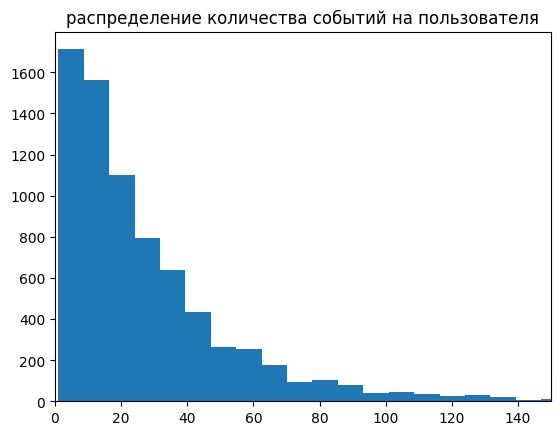

In [20]:
display(logs.groupby('user_id', as_index = False)['event'].agg('count').describe())

plt.hist(logs.groupby('user_id', as_index = False)['event'].agg('count')['event'], bins = 300)
plt.xlim(0,150)
plt.title('распределение количества событий на пользователя')
plt.show();

Медианное значение распределения количества событий на пользователя составляет 20 событий на пользователя в течение имеющегося промежутка времени. Гистограмма более подробно показывает как распределяются количества событий по пользователям.

Определим, данными за какой период мы располагаем. Найдем минимальную и максимальную даты

In [21]:
logs['date'].min(), logs['date'].max()

(Timestamp('2019-07-25 00:00:00'), Timestamp('2019-08-08 00:00:00'))

У нас есть данные за две недели.

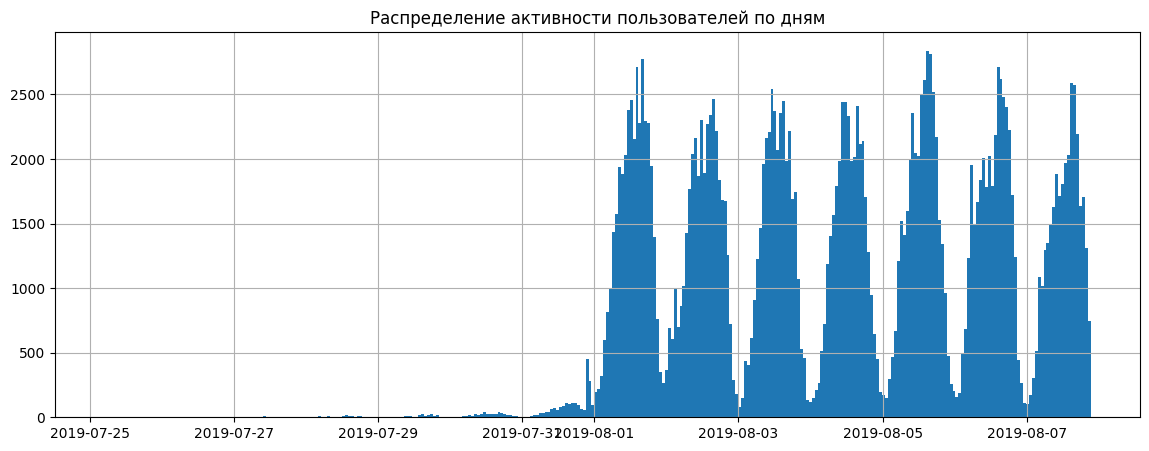

In [22]:
# распределение активности пользователей по времени
logs['date_and_time'].hist(bins=14*24, figsize=(14, 5))
plt.title('Распределение активности пользователей по дням');   

In [23]:
logs.groupby('date', as_index = False)['user_id'].agg('count')

,date,user_id
0,2019-07-25,7
1,2019-07-26,32
2,2019-07-27,55
3,2019-07-28,103
4,2019-07-29,179
5,2019-07-30,386
6,2019-07-31,1171
7,2019-08-01,34814
8,2019-08-02,35284
9,2019-08-03,34137


В некоторые дни активность пользователей очень низкая. Очевидно, что часть данных отсутствует.

Полные данные имеются только в период с 1 августа по 7 августа включительно. Неполные данные придется отбросить.

In [24]:
log = logs.query('date >= "2019-08-01"')

In [25]:
log

,event,user_id,date,group,date_and_time
1933,main,2386905776711210873,2019-08-01,A1,2019-07-31 20:00:03
1934,offers,2659616611828697302,2019-08-01,B,2019-07-31 20:00:43
1935,offers,5638333191822379090,2019-08-01,B,2019-07-31 20:00:46
1936,main,2419517597868248322,2019-08-01,A2,2019-07-31 20:02:42
1937,main,4649999248492122991,2019-08-01,B,2019-07-31 20:05:01
...,...,...,...,...,...
243708,main,4599628364049201812,2019-08-08,A2,2019-08-07 21:12:25
243709,main,5849806612437486590,2019-08-08,A1,2019-08-07 21:13:59
243710,main,5746969938801999050,2019-08-08,A1,2019-08-07 21:14:43
243711,main,5746969938801999050,2019-08-08,A1,2019-08-07 21:14:58


Посчитаем, какой процент событий и пользователей мы потреяли, отбросив данные:

In [26]:
round((1-log['event'].count()/logs['event'].count())*100, 1)

0.8

Отбросив данные, мы потеряли всего 1.2% событий.

Посмотрим, на сколько уменьшилось количество событий в каждой из групп

In [27]:
(1- log['group'].value_counts() / logs['group'].value_counts())*100

B     0.800402
A1    0.765767
A2    0.813342
Name: group, dtype: float64

Потери составили от 1.1% до 1.4%

Рассчитаем, сколько уникальных пользователей потерялось при удалении данных:

In [28]:
logs['user_id'].nunique() - log['user_id'].nunique(),\
round((1-log['user_id'].nunique()/logs['user_id'].nunique())*100,2)

(13, 0.17)

Отбросив данные, мы потеряли 17 уникальных пользователей, что составляет 0.23% от общего количества уникальных пользователей.

In [29]:
log['group'].value_counts()

B     84897
A1    79567
A2    77316
Name: group, dtype: int64

В каждой из тестируемых групп остались пользователи.

In [30]:
(
log
    .groupby('user_id')
    .agg({'group' : 'nunique'})
    .query('group>1')
)

,group
user_id,


Пользователей состоящих более, чем в одной группе, нет.

## Воронка событий 

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [31]:
log['event'].value_counts()

main        117919
offers       46546
cart         42351
payment      33954
tutorial      1010
Name: event, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [32]:
funnel = (
    log.groupby('event', as_index = False)['user_id'].nunique()
    .sort_values(by = 'user_id', ascending = False)
)
funnel.columns = ['event', 'users']
funnel

,event,users
1,main,7423
2,offers,4598
0,cart,3736
3,payment,3540
4,tutorial,843


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [33]:
funnel['conversion'] = round((funnel['users']/log['user_id'].nunique())*100,2)

funnel

,event,users,conversion
1,main,7423,98.47
2,offers,4598,61.00
0,cart,3736,49.56
3,payment,3540,46.96
4,tutorial,843,11.18


События должны происходить следующим образом:
1. пользователь в первый раз заходит в приложение, ему показывают обучение (`tutorial`), 
2. далее он попадает на главную страницу (`main`), 
3. далее пользователь ищет продукт и попадает на страницу с предложениями (`offers`),
4. понравившийся товар поьзователь добавляет в корзину и переходит на страницу корзины (`cart`),
5. на странице корзины пользователь оформляет и оплачивает заказ и переходит на страницу оплаты (`payment`).

Несмотря на то, что в идеальном случае процент прошедших обучение должне быть самым высоким, в нашем случае он самый низкий. Вероятно это связано с тем, что пользователи попросту пропускают обучение.

Поскольку, обучение является опциональным, может происходить на любом этапе работы с приложением и никак не вписывается в воронку, удалим данную строку, поскольку она не несет никакой ценности.

В остальном, доли пользователей распределяются так, как должно, аномалий не наблюдается.

In [34]:
funnel.drop(funnel[funnel.event =='tutorial'].index, inplace = True)
funnel

,event,users,conversion
1,main,7423,98.47
2,offers,4598,61.00
0,cart,3736,49.56
3,payment,3540,46.96


In [35]:
funnel['step_conversion'] = round(
    (funnel['conversion'] / funnel['conversion'].shift())*100, 2
)

funnel

,event,users,conversion,step_conversion
1,main,7423,98.47,NaN
2,offers,4598,61.00,61.95
0,cart,3736,49.56,81.25
3,payment,3540,46.96,94.75


Наибольшее количество пользователей теряется при переходе с главной страницы на страницу с товарами, вероятно имеются проблемы с поисковой системой.

От первого события до оплаты доходит 46.97% пользователей.

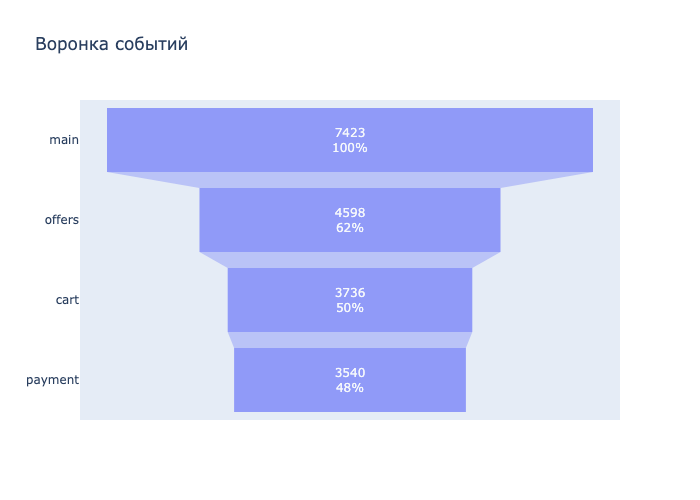

In [36]:
fig = fig = go.Figure(go.Funnel(
    y = funnel['event'],
    x = funnel['users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65
    ))

fig.update_layout(title_text='Воронка событий')
fig.show()

## Изучение результатов экспериментов

Посчитаем количество пользователей в каждой экспериментальной группе.

In [37]:
log.groupby('group', as_index = False)['user_id'].agg('nunique')

,group,user_id
0,A1,2484
1,A2,2517
2,B,2537


Количество пользователей неравномерно, разница между группой В и А1 составляет 53 пользователя.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (А1 и А2).

Для этого используем z-тест, то есть сравним пропорции двух генеральных совокупностей по выборкам из них. 

---

Для удобства последующих расчетов разобьем воронку событий по экспериментальным группам, добавим столбец с количеством уникальных пользователей, а также на всякий случай рассчитаем конверсию и шаговую конверсию, чтобы убедиться, что ни в одной из групп нет аномалий:

In [38]:
funnel_a1 = (
    log.query('group == "A1"')
    .groupby("event", as_index=False)["user_id"].nunique()
    .sort_values(by="user_id", ascending=False)
)
funnel_a1.columns = ["event", "users"]

funnel_a1['total_users'] = log.query('group == "A1"')['user_id'].nunique()
funnel_a1["conversion"] = round(
    (funnel_a1["users"] / log.query('group == "A1"')["user_id"].nunique()) * 100, 2
)
funnel_a1["step_conversion"] = round(
    (funnel_a1["conversion"] / funnel_a1["conversion"].shift()) * 100, 2
)


funnel_a2 = (
    log.query('group == "A2"')
    .groupby("event", as_index=False)["user_id"].nunique()
    .sort_values(by="user_id", ascending=False)
)

funnel_a2.columns = ["event", "users"]
funnel_a2['total_users'] = log.query('group == "A2"')['user_id'].nunique()
funnel_a2["conversion"] = round(
    (funnel_a2["users"] / log.query('group == "A2"')["user_id"].nunique()) * 100, 2
)
funnel_a2["step_conversion"] = round(
    (funnel_a2["conversion"] / funnel_a2["conversion"].shift()) * 100, 2
)

funnel_b = (
    log.query('group == "B"')
    .groupby("event", as_index=False)["user_id"].nunique()
    .sort_values(by="user_id", ascending=False)
)

funnel_b.columns = ["event", "users"]
funnel_b['total_users'] = log.query('group == "B"')['user_id'].nunique()
funnel_b["conversion"] = round(
    (funnel_b["users"] / log.query('group == "B"')["user_id"].nunique()) * 100, 2
)
funnel_b["step_conversion"] = round(
    (funnel_b["conversion"] / funnel_b["conversion"].shift()) * 100, 2
)

funnel_a1, funnel_a2, funnel_b

(      event  users  total_users  conversion  step_conversion
 1      main   2450         2484       98.63              NaN
 2    offers   1542         2484       62.08            62.94
 0      cart   1266         2484       50.97            82.10
 3   payment   1200         2484       48.31            94.78
 4  tutorial    278         2484       11.19            23.16,
       event  users  total_users  conversion  step_conversion
 1      main   2479         2517       98.49              NaN
 2    offers   1524         2517       60.55            61.48
 0      cart   1239         2517       49.23            81.30
 3   payment   1158         2517       46.01            93.46
 4  tutorial    284         2517       11.28            24.52,
       event  users  total_users  conversion  step_conversion
 1      main   2494         2537       98.31              NaN
 2    offers   1532         2537       60.39            61.43
 0      cart   1231         2537       48.52            80.34
 3   p

Аномалий не обнаружено, двигаемся дальше.

Самым популярным событием для каждой из групп является переход на главную страницу (`main`).

In [39]:
funnel_a1, funnel_a2, funnel_b

(      event  users  total_users  conversion  step_conversion
 1      main   2450         2484       98.63              NaN
 2    offers   1542         2484       62.08            62.94
 0      cart   1266         2484       50.97            82.10
 3   payment   1200         2484       48.31            94.78
 4  tutorial    278         2484       11.19            23.16,
       event  users  total_users  conversion  step_conversion
 1      main   2479         2517       98.49              NaN
 2    offers   1524         2517       60.55            61.48
 0      cart   1239         2517       49.23            81.30
 3   payment   1158         2517       46.01            93.46
 4  tutorial    284         2517       11.28            24.52,
       event  users  total_users  conversion  step_conversion
 1      main   2494         2537       98.31              NaN
 2    offers   1532         2537       60.39            61.43
 0      cart   1231         2537       48.52            80.34
 3   p

Присвоим имена датафреймам:

In [40]:
funnel_a1.name = 'A1'
funnel_a2.name = 'A2'
funnel_b.name = 'B'

Для удобства последующего определения статистической достоверности различия между группами, напишем функцию (поскольку будет проверяться множество гипотез - 4 для A/A-теста и 12 для A/B-тестов, применим поправку Бонферрони):

In [41]:
def z_test (df1, df2, event, alpha, m):

    alpha_bonferron = alpha/m
    total_users = np.array([df1['total_users'][0],
                            df2['total_users'][0]])
    
    event_users = np.array([df1[df1['event'] == event]['users'],
                            df2[df2['event'] == event]['users']])

    # доля пользователей, совершивших событие в первой группе:
    p1 = event_users[0]/total_users[0]

    # доля пользователей, совершивших событие во второй группе:
    p2 = event_users[1]/total_users[1]

    # доля пользователей, совершивших событие в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (total_users[0] + total_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Сравнение долей в группах:', df1.name, 'и', df2.name )
    print('Событие:', event)    
    print('p-значение: ', p_value)

    if p_value < alpha_bonferron:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Функция написана, далее проведем сравнение гипотез о равенстве долей пользователей между контрольными группами A1 и A2.

**Нулевая гипотеза**: доли уникальных пользователей, совершивших событие, равны.

**Альтернативная гипотеза**: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница..

In [42]:
for event in funnel_a1['event']:
    z_test(funnel_a1, funnel_a2, event, 0.05, 4)
    print()

Сравнение долей в группах: A1 и A2
Событие: main
p-значение:  [0.67562177]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и A2
Событие: offers
p-значение:  [0.26698769]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и A2
Событие: cart
p-значение:  [0.21828121]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и A2
Событие: payment
p-значение:  [0.10298395]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и A2
Событие: tutorial
p-значение:  [0.91827903]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Нулевая гипотеза подтверждена - при заданном уровне значимости между группами А1 и А2 нет статистически достоверного различия ни в одном из событий.

Теперь сравним одну из А групп с группой В:

In [43]:
# сравнение групп A1 и B
for event in funnel_a1['event']:
    z_test(funnel_a1, funnel_b, event, 0.05, 12)
    print()

Сравнение долей в группах: A1 и B
Событие: main
p-значение:  [0.34705881]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и B
Событие: offers
p-значение:  [0.21886922]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и B
Событие: cart
p-значение:  [0.08328413]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и B
Событие: payment
p-значение:  [0.22269359]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1 и B
Событие: tutorial
p-значение:  [0.89644896]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [44]:
# сравнение групп A2 и B
for event in funnel_a1['event']:
    z_test(funnel_a2, funnel_b, event, 0.05, 12)
    print()

Сравнение долей в группах: A2 и B
Событие: main
p-значение:  [0.60016616]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A2 и B
Событие: offers
p-значение:  [0.90625093]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A2 и B
Событие: cart
p-значение:  [0.61695175]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A2 и B
Событие: payment
p-значение:  [0.67754136]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A2 и B
Событие: tutorial
p-значение:  [0.8151967]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Также, сравним результаты с объединённой контрольной группой.

In [45]:
funnel_a_comb = funnel_a1[['users', 'total_users']] + funnel_a2[['users', 'total_users']]
funnel_a_comb['event'] = funnel_a1['event']
funnel_a_comb.drop(funnel_a_comb[funnel_a_comb.event =='tutorial'].index, inplace = True)
funnel_a_comb.name = 'A1+A2'
funnel_a_comb

,users,total_users,event
1,4929,5001,main
2,3066,5001,offers
0,2505,5001,cart
3,2358,5001,payment


In [46]:
# сравнение групп A2 и B
for event in funnel_a1['event']:
    z_test(funnel_a_comb, funnel_b, event, 0.05, 12)
    print()

Сравнение долей в группах: A1+A2 и B
Событие: main
p-значение:  [0.39298915]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1+A2 и B
Событие: offers
p-значение:  [0.43830674]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1+A2 и B
Событие: cart
p-значение:  [0.19819341]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1+A2 и B
Событие: payment
p-значение:  [0.64520577]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение долей в группах: A1+A2 и B
Событие: tutorial
p-значение:  [nan]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Различий не обнаружено, значит **нет оснований считать, что изменение шрифтов повлияло на поведение пользователей**.

## Вывод

Было проанализировано поведение 7533 уникальных пользователей мобильного приложения в период с 01.08.2019 по 07.08.2019.

Из них:
* 842 (11.2%) - прошли обучение,
* 7418 (98.5%) - посетили главную страницу,
* 4592 (61%) - зашли на страницу с товаром,
* 3732 (49.5%) - положили товар в корзину,
* 3538 (47%) - оплатили товар.

Несмотря на то, что в идеальном случае процент прошедших обучение должен быть самым высоким, в нашем случае он самый низкий. Вероятно это связано с тем, что пользователи попросту пропускают обучение.

Наибольшее количество пользователей (шаговая конверсия - 61.9%) теряется при переходе с главной страницы на страницу с товарами, вероятно имеются технические проблемы с поисковой системой (плохо работает выдача необходимого товара по запросу, пользователь не может найти поле с поиском), либо у пользователя возникают проблемы непосредственно при переходе на страницу с товаром. **Рекомендуется** проверить приложение на наличие неисправностей.

При анализе A/A/B-теста было обнаружено, что:
* между контрольными группами 246 (А1) и 247 (А2) различий не наблюдается,
* сравнение экспериментальной группы 248 (B) с контрольными - с каждой по отдельности и с объединенной - показало, что различий между ними также нет.

Таким образом, можно сделать вывод, что изменение шрифта **не повлияло** на поведение пользователей.